In [ ]:
!pip3 install brevitas -q
# !pip install brevitas -q
# %xmode Verbose
# !pip install line_profiler -q
# %load_ext line_profiler

In [4]:
import torch
import brevitas
import numpy as np
import matplotlib.pyplot as plt
import time
import sys
import os
import cv2 as cv

colab = True
colab = False
unzip = True
unzip = False

# models_path = '/models_LN5'
# models_path = '/models_LN6'
# models_path = '/models_LN7'
# models_path = '/models_LN7_gciou'
# models_path = '/models_LN7_ciou'
models_path = '/models_LN7_ciou_original'
# models_path = '/models_LN7_quant'

if colab:
    from google.colab import drive
    import zipfile

    dataset_local_path='/content/Merged_dataset'
    path_to_folds_state = '/folds_state_path_bbox.pkl'
    local_g_drive = '/content/drive'

    # mount g_drive and update paths
    drive.mount(local_g_drive)
    # path directory with DAC SDC 2021
    drive_path = local_g_drive+'/MyDrive/SOD_custom_FINN_VAI/TRAIN'
    # subdirectory with models
    models_path = drive_path+models_path
    # path to folds split data and it's state
    path_to_folds_state = drive_path+path_to_folds_state

    # unzip files frm g_drive zip
    path_to_zip_file = drive_path+'/Merged_dataset.zip'
    directory_to_extract_to = dataset_local_path[:-len('/Merged_dataset')]
    # Unzip if not unzipped
    if unzip and (len([f for f in os.listdir('/content') if os.path.isdir(os.path.join('/content', f))]) < 4 \
        or len(os.listdir(dataset_local_path+'/images'))  < 145):
        print("unpacking to ",dataset_local_path)
        with zipfile.ZipFile(path_to_zip_file, 'r') as zip_ref:
            zip_ref.extractall(directory_to_extract_to)

else:
    dataset_local_path='/media/michal/HDD_Linux_2/DATASETS/Merged_dataset'
    path_to_folds_state = 'folds_state_path_bbox.pkl'
    local_g_drive = './'

    # path directory with DAC SDC 2021 - current directory
    drive_path = local_g_drive
    # subdirectory with models
    models_path = drive_path+models_path
    # path to folds split data and it's state
    path_to_folds_state = drive_path+path_to_folds_state

"""add path to allow import!!!"""
sys.path.append(drive_path)

# get device to execute 
use_cuda = torch.cuda.is_available()
# use_cuda = False
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

import callbacks
import criterions
import preprocessing
import training
import utils
import metrics
import quantizers as quant
import networks
import schedulers

cuda


In [5]:

# image_shape = (100, 200, 3)
image_shape = (112, 208, 3)

after_load = preprocessing.numpy_to_torch_iou_params(device)
to_anchors_single = lambda *x: preprocessing.to_anchors_for_iou_loss(*x,False,False)
# to_anchors_multi = lambda *x: preprocessing.to_anchors_for_iou_loss(*x,True,True)
to_anchors_multi = lambda *x: preprocessing.to_anchors_for_iou_loss(*x,True,False)
# to_anchors_single = to_anchors_multi

anchors = [22,33,
            5,10,
            15,5
          ]
anchors = np.array(anchors, np.float32).reshape((-1,2))

# normalize anchors
anchors *= np.array([[image_shape[0]/340, image_shape[1]/640]])

qwi8 = quant.generalized_auto_fxp(bit_width=8, frac_part=6, signed=0.1, 
                                max_bit_width=8, min_bit_width=8, round_mode='floor',
                                trainable_signed=False, trainable_bit_width=False,
                                trainable_scale=False, dst='act')
qw8 = quant.generalized_auto_fxp(bit_width=7,frac_part=5, signed=0.7,
                                 min_bit_width=4, max_bit_width=8, dst='weight',)
qb8 = quant.generalized_auto_fxp(bit_width=7,frac_part=5, signed=0.7,
                                 min_bit_width=4, max_bit_width=8, dst='bias',)
qa = quant.generalized_auto_fxp(bit_width=5,frac_part=2, signed=0.7,
                                 min_bit_width=2, max_bit_width=8, dst='act',)
quant_input = qwi8
quant_medium = (qw8,None,qa,qb8)
quant_out = (qw8,None,qa,qb8)


networks.SeparableConv2D.QUANT_BEFORE_BN = True
# networks.QuantBatchNorm.ALLOW_QUANTIZATION = False
# networks.QuantBatchNorm.ALLOW_QUANTIZATION = True
# net = networks.LittleNet5(anchors.shape[0], None, (None,None,None,None), (None,None,None,None), device=device)
# net = networks.LittleNet6(anchors.shape[0], None, (None,None,None,None), (None,None,None,None), device=device)
net = networks.LittleNet7(anchors.shape[0], None, (None,None,None,None), (None,None,None,None), device=device)
# net = networks.LittleNet7(anchors.shape[0], quant_input, quant_medium, quant_out, device=device)

# pass example tensor
torch.cuda.empty_cache()
tensor = torch.rand((8,3,)+image_shape[:2]).to(device)
print("Input shape =",tensor.shape)
with torch.no_grad():
    result = net(tensor)

print("Result shape =",result.shape)

# get yolo paremeters
# output_sizes = net.output_sizes(input_size=image_shape[:2][::-1])[-1,:]
output_sizes = np.array(result.shape[2:][::-1])
p_num = networks.get_number_of_params(net)
del tensor
del result

print("Anchors: ")
print(anchors) 
print("Output sizes: ")
print(output_sizes) 
print("Number of parameters: ")
print(p_num) 

# CREATE GENERATORS
def numpy_to_tensor(X,y,device=device):
    return utils.data_to_tensor_v3(X,y,device)
(None,None,None,None)
grid_WH2 = image_shape[:2][::-1] // (2*output_sizes)
# create Transformer object
transform = preprocessing.Transformer(generator=np.random.default_rng(), 
                            noise=0.02, 
                            horizontal_flip=(), 
                            vertical_flip=(), 
                            rotate=(-15,15), 
                            # equalize_hist=0.05, 
                            blur=7,
                            scale=(0.8, 1.5),
                            translate=((-grid_WH2[0], grid_WH2[0]),
                                       (-grid_WH2[1], grid_WH2[1])),
                            HSV=0.005,
                            LAB=0.005,
                            YCrCb=0.005,
                            )
# create generators without data => generators templates
train_generator = preprocessing.YoloDataGenerator(
                            dataset_local_path,
                            input_shape=image_shape,
                            anchors=anchors,
                            images_labes=[],# [(img_path, bbox_path),] 
                            batch_size=64,
                            name='TrainGenerator', 
                            augmentator=transform,
                            output_size=output_sizes,
                            after_load=after_load,
                            # depends on model
                            bbox_to_anchors=to_anchors_multi,
                            )
val_generator = preprocessing.YoloDataGenerator(
                            dataset_local_path,
                            input_shape=image_shape,
                            anchors=anchors,
                            images_labes=[], 
                            batch_size=64,
                            name='ValGenerator', 
                            augmentator=None,
                            output_size=output_sizes,
                            after_load=after_load,
                            # bbox_to_anchors=to_anchors_single,
                            bbox_to_anchors=to_anchors_multi,
                            )
test_generator = preprocessing.YoloDataGenerator(
                            dataset_local_path,
                            input_shape=image_shape,
                            anchors=anchors,
                            images_labes=[], 
                            batch_size=64,
                            name='TestGenerator', 
                            augmentator=None,
                            output_size=output_sizes,
                            after_load=after_load,
                            # bbox_to_anchors=to_anchors_single,
                            bbox_to_anchors=to_anchors_multi,
                            )

# PATHS FORMATS
# paths format is (fold_idx, '{}') - to be possible next format
checkpoint_format_path = models_path+'/model_chp_fold_{}_epoch_{}.pt'
best_format_path = models_path+'/model_best_fold_{}.pt'
best_iou_format_path = models_path+'/model_best_iou_fold_{}.pt'
last_format_path = models_path+'/model_last_fold_{}.pt'
global_last_path = models_path+'/network_model_last.pt' 


Input shape = torch.Size([8, 3, 112, 208])
Result shape = torch.Size([8, 15, 7, 13])
Anchors: 
[[ 7.247059  10.725    ]
 [ 1.6470588  3.25     ]
 [ 4.9411764  1.625    ]]
Output sizes: 
[13  7]
Number of parameters: 
243919


In [3]:

print("Num of params:", networks.get_number_of_params(net))

# get layers outputs
with torch.no_grad():
    t = torch.rand(1,3,*image_shape[:2], device=device)
    ans = net.multioutput_forward(t)[:-2]

layers_outputs = np.array([list(a.size()) for a in ans])

# get params as [ ([filters, filter_len],is_dw, paralellism),...]
params = []
layers = net.layers[1:-1]

for i, L in enumerate(layers):
    p = networks.get_number_of_params(L)
    is_dw = type(L) is networks.DWConv2d
    ch_out = L.out_channels
    
    if is_dw:
        paralellism = 1
    elif i+1 == len(layers):
        paralellism = 5
    else:
        ceil = lambda *x: int((x[0]-1)/x[1] +1)
        paralellism = 16 if ceil(ch_out,16) == ceil(ch_out,18) else 18

    paralellism = min(ch_out, paralellism)

    params.append(([ch_out, p//ch_out], is_dw, paralellism))

# get buffers BRAMs and assigned layers
in_layer,\
blocks_buffers,\
out_layer,\
assignments = utils.buffers_brams_usage(layers_outputs,
                                        layers_per2buffers=4, 
                                    #    separate_out=False
                                        separate_out=True
                                        )
# get ROMs BRAMs
blocks_roms = utils.roms_usage(params,bit_width=8)

# print buffers
name = "{}_{:02}_{:1}: {:3.0f} BRAMS layers={} shapes={}"
shapes = np.array(layers_outputs)[:,1:]
print(name.format("In_", 0, 0, in_layer, [0], shapes[0,:].tolist()))
for blk_idx, blk in enumerate(blocks_buffers):
    for buff_idx, buff in enumerate(blk):
        layers_idx = assignments[blk_idx][buff_idx]
        print(name.format("Blk",blk_idx+1, buff_idx, buff, layers_idx, shapes[layers_idx,:].tolist()))
print(name.format("Out", len(blocks_buffers)+1, 0, out_layer, [len(layers_outputs)-1],shapes[-1,:].tolist()))

# print ROMS
templ = 'P_{:2}: shape={:10} type={:2} parallelism={:2} => {:3}'
for i, ((shape,is_dw, paralellism),(brams)) in enumerate(zip(params,blocks_roms)):
    print(templ.format(i,str(shape),'dw' if is_dw else 'pw', paralellism, brams))

tot_roms_bram = sum(blocks_roms)
tot_buff_bram = in_layer+np.sum(blocks_buffers) # out_layer

print("Total {} BRAM used by BUFFERs".format(tot_buff_bram))
print("Total {} BRAM used by ROMs".format(tot_roms_bram))
print("Total {} BRAM usage".format(tot_roms_bram+tot_buff_bram))
print("Total {} DSP48 usage".format(utils.DSP_cout(params)))

Num of params: 243919
In__00_0:  18 BRAMS layers=[0] shapes=[3, 112, 208]
Blk_01_0:  35 BRAMS layers=[1, 3] shapes=[[6, 112, 208], [8, 56, 104]]
Blk_01_1:  23 BRAMS layers=[2, 4] shapes=[[8, 56, 104], [16, 56, 104]]
Blk_02_0:  23 BRAMS layers=[5, 7] shapes=[[32, 28, 52], [64, 28, 52]]
Blk_02_1:  12 BRAMS layers=[6, 8] shapes=[[32, 28, 52], [64, 14, 26]]
Blk_03_0:   6 BRAMS layers=[9, 11] shapes=[[64, 14, 26], [128, 7, 13]]
Blk_03_1:  12 BRAMS layers=[10, 12] shapes=[[128, 14, 26], [128, 7, 13]]
Blk_04_0:   6 BRAMS layers=[13, 15] shapes=[[256, 7, 13], [256, 7, 13]]
Blk_04_1:  12 BRAMS layers=[14, 16] shapes=[[256, 7, 13], [512, 7, 13]]
Blk_05_0:   6 BRAMS layers=[17] shapes=[[256, 7, 13]]
Blk_05_1:   0 BRAMS layers=[] shapes=[]
Out_06_0:   6 BRAMS layers=[18] shapes=[256, 7, 13]
P_ 0: shape=[6, 11]    type=dw parallelism= 1 => 0.5
P_ 1: shape=[8, 9]     type=pw parallelism= 8 => 1.5
P_ 2: shape=[8, 12]    type=dw parallelism= 1 => 0.5
P_ 3: shape=[16, 11]   type=dw parallelism= 1 => 0.

In [14]:
# save only weights to file
# src_dict = torch.load(global_last_path, map_location=torch.device(device))
# utils.plot_history(src_dict['history'])

# torch.save(src_dict['model'], models_path+'/weights_only.pth')

In [3]:
create_trainer_again = True
# create_trainer_again = False

lr = 0.1
momentum = 0.9
# optimizer = torch.optim.Adadelta(net.parameters(), lr=lr, weight_decay=0.0001)
optimizer = torch.optim.SGD(net.parameters(), lr=lr, momentum=momentum)
# optimizer = torch.optim.Adam(net.parameters(), lr=lr)

if create_trainer_again:
    # init all obejcts once

    # criterion
    loss_criterion = criterions.YoloIOULoss(anchors, 
                                            input_shape=image_shape, 
                                            # weights=[20,1],
                                            weights=[1,1],
                                            # iou_mode='gciou')
                                            iou_mode='ciou')
    criterion = criterions.Regularization(loss_fcn=loss_criterion,
                                          regularization_loss=criterions.mean_sqare_value,
                                          weights=[1.0, 0.00001])

    # create metrics
    iou = metrics.SingleObjectIOUsBasedMetrics(anchors.copy(),image_shape, device=device)
    giou, diou, ciou = iou.get_gdciou()

    reg_loss_metric = metrics.ProxyAttributeMetric(criterion, 'reg_loss')
    loss_validity_metric = metrics.ProxyAttributeMetric(criterion.loss_fcn, 'loss_validity')
    loss_iou_metric = metrics.ProxyAttributeMetric(criterion.loss_fcn, 'loss_iou')

    # create callbacks
    checkpoint = callbacks.Checkpoint(checkpoint_format_path.format(-1,'{}'))
    best = callbacks.SaveBest(best_format_path.format(-1),monitored=['loss','val_loss'], multipliers=[-1, -1])
    best_iou = callbacks.SaveBest(best_iou_format_path.format(-1),monitored=['val_iou'], multipliers=[1])
    last = callbacks.SaveLast(last_format_path.format(-1))
    last_global = callbacks.SaveLast(global_last_path)
    early_stopping = callbacks.EarlyStopping(filter_size=5, threshold=0.3)
    # plot_clb = callbacks.PlotHistory(5)

    # create scheduler
    scheduler_ = schedulers.LossDependentScheduler(mul=1.3, div=2.0, init_loss=-np.inf, init_lr=lr, lr_min=1e-5, lr_max=1.0)
    # scheduler_ = schedulers.BaseScheduler()
    # group metrics and callbacks
    metrics_dict = {'r_l':reg_loss_metric,'obj_l':loss_validity_metric,'iou_l':loss_iou_metric,'iou': iou, 'giou':giou, 'diou':diou, 'ciou':ciou}
    callbacs_list = [checkpoint,
                     best,best_iou, 
                     last,last_global,
                     early_stopping,
                    #  plot_clb, 
                     ]

    trainer = training.Trainer(net,
                            criterion=criterion,
                            optimizer=optimizer,
                            name='Trainer',
                            metrics=metrics_dict,
                            callbacks=callbacs_list,
                            checkpoint_clb=checkpoint,
                            best_clb=best,
                            best_iou_clb=best_iou,
                            last_clb=last,
                            last_global_clb=last_global,
                            early_stopping=early_stopping,
                            # plotter=plot_clb,
                            info=['LittleNet7 non quant, ciou original, with input '+str(image_shape)],
                            anchors_wh=anchors,
                            scheduler=scheduler_,
                            fold_state=-1)

    torch.save(trainer.get_state(), global_last_path)
    
    print("Trainer object created and saved at", global_last_path)


Trainer object created and saved at .//models_LN7_gciou/network_model_last.pt


In [58]:
# SPLIT DATASET ONTO TESTSET and TRAIN-VAL FOLDS
# DO IT ONCE
split_again = False

if split_again:
    # get and split data
    dataset = utils.get_all_imgs_gts(dataset_local_path)
    training_dataset, test_dataset = utils.train_test_split(dataset, 0.4)

    # create folds split for cross validation
    folds_of_dicts = utils.split_into_folds(training_dataset, 5)
    folds = utils.folds_dict_to_folds_list(folds_of_dicts)
    # train set for final evaluation
    test_set = utils.dataset_to_list(test_dataset)
        
    # create folds wrapper 
    folds_state = training.FoldsState(folds=folds, state=0, test_set=test_set)

    training.save_folds(folds_state, path_to_folds_state)

    print("Data splited into folds")

In [31]:
# d = {'folds':{},
#      'test':[]}
# for idx, f in enumerate(folds_state.folds):
#     Ld = {i:{'path':p,'bbox':dict(zip(['l','t','r','b'],np.round(utils.xcycwh_to_ltrb(bbox.copy().reshape(1,4))).flatten().astype(int).tolist()))} for i, (p,bbox) in enumerate(f)}
#     d['folds'][idx] = Ld
#     pass
    
# d['test'] = {i:{'path':p,'bbox':dict(zip(['l','t','r','b'],np.round(utils.xcycwh_to_ltrb(bbox.copy().reshape(1,4))).flatten().astype(int).tolist()))} for i, (p,bbox) in enumerate(folds_state.test_set)}

# for k,v in d['folds'].items():
#     print(k, len(v))
#     print(v[0])
# print(d['test'][0])

# import json

# with open('splited_data_set.json', 'w') as f:
#     as_str = json.dumps(d,indent=True)
#     f.write(as_str)

    

0 29417
{'path': 'images/CarScale/0230.jpg', 'bbox': {'l': 129, 't': 108, 'r': 424, 'b': 219}}
1 29417
{'path': 'images/carchase/00002402.jpg', 'bbox': {'l': 162, 't': 102, 'r': 205, 'b': 129}}
2 29417
{'path': 'images/Mhyang/0237.jpg', 'bbox': {'l': 115, 't': 46, 'r': 180, 'b': 122}}
3 29417
{'path': 'images/liverRun/00028533.jpg', 'bbox': {'l': 168, 't': 77, 'r': 285, 'b': 141}}
4 29158
{'path': 'images/sitcom/00002506.jpg', 'bbox': {'l': 374, 't': 40, 'r': 456, 'b': 151}}
{'path': 'images/horseride/00011514.jpg', 'bbox': {'l': 517, 't': 323, 'r': 556, 'b': 383}}


In [ ]:
# load state 
folds_state = training.load_folds(path_to_folds_state)
state_dict = torch.load(global_last_path, map_location=torch.device(device))
state_dict = torch.load(best_format_path.format(0), map_location=torch.device(device))
# state_dict = torch.load(checkpoint_format_path.format(0, 69), map_location=torch.device(device))
trainer = training.load_trainer(net, optimizer, state_dict, device)

# trainer.additional_state['scheduler'] = schedulers.LossDependentScheduler(mul=1.3, div=2.0, init_loss=-np.inf, init_lr=lr, lr_min=1e-4, lr_max=1.0)
# trainer.criterion.loss_fcn.weights = [1.0,2.0]
# trainer.criterion.loss_fcn.input_shape = torch.tensor(image_shape)
# trainer.metrics['iou'].img_shape = image_shape
# trainer.criterion.regularization_loss = criterions.NearestQuantLoss(8, 2, signed=True, narrow_range=False)
# trainer.criterion.regularization_loss.norm = torch.abs
# trainer.criterion.regularization_loss.reduction = torch.max

# trainer.criterion.loss_fcn.iou_mode = 'gciou'
# # additional notes
# trainer.additional_state['info'].append(str(trainer.epoch)+' - scheduler LD')
# trainer.additional_state['info'] = trainer.additional_state['info'][:-1]
# trainer.additional_state['info'].append(str(trainer.epoch)+' - ciou alpha always 1 validity loss from 1 to 100')
# torch.save(trainer.get_state(), global_last_path)
# trainer.additional_state['best_iou_quant_clb'].best *= 0

# trainer.additional_state['info'].append(str(trainer.epoch)+' - start trainable fixedpoint quantization')
trainer.to(device)

print(trainer.additional_state.keys())
print(trainer.additional_state['info'])

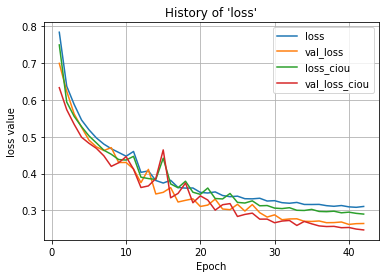

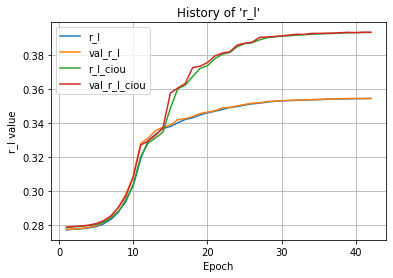

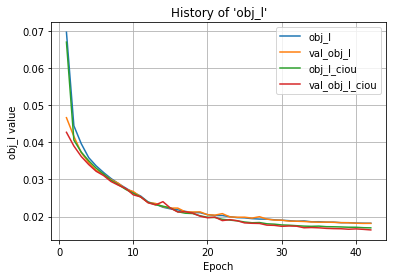

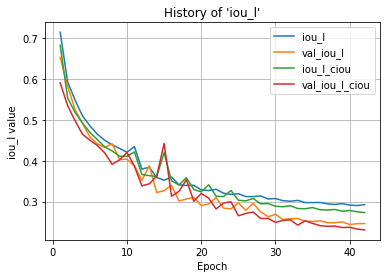

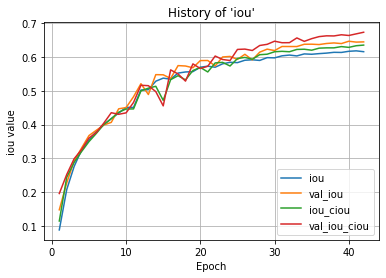

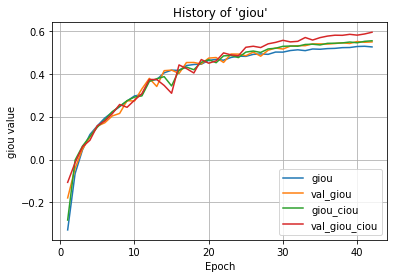

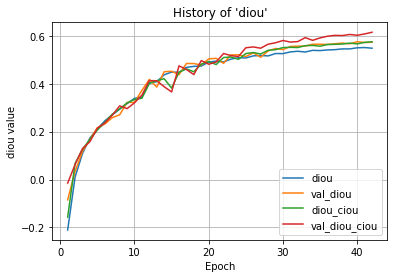

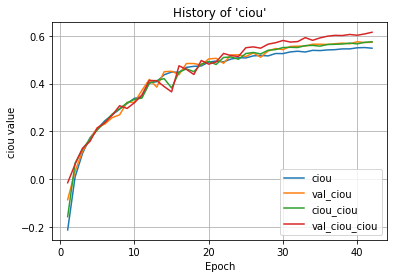

In [65]:
# h = {k+'_ciou':v[:43] for k,v in trainer.history.items()}
# h.update(trainer.history)
plt.grid(True)
hist = h
keys = [k for k in hist.keys() if 'val_' not in k and '_ciou' not in k ]

for k in keys:
    v1 = hist[k]
    v2 = hist['val_'+k]
    v3 = hist[k+'_ciou']
    v4 = hist['val_'+k+'_ciou']
    
    v1 = [v.item() if isinstance(v, torch.Tensor) else v for v in v1]
    v2 = [v.item() if isinstance(v, torch.Tensor) else v for v in v2]
    v3 = [v.item() if isinstance(v, torch.Tensor) else v for v in v3]
    v4 = [v.item() if isinstance(v, torch.Tensor) else v for v in v4]

    size = min(len(v1),len(v2),len(v3),len(v4))
    x = np.arange(0,size)+1

    plt.plot(x, v1[:size], label=k)
    plt.plot(x, v2[:size], label='val_'+k)
    plt.plot(x, v3[:size], label=k+'_ciou')
    plt.plot(x, v4[:size], label='val_'+k+'_ciou')
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel(k+' value')
    plt.title("History of '{}'".format(k))
    plt.grid(True)
    plt.show()

# utils.plot_history(h)

In [7]:
# HERE IS MAIN CROSS-VALIDATION LOOP

epochs_limit = 350
if device == torch.device('cpu') and False:
    train_generator.batch_size = 2
    val_generator.batch_size = 4
    test_generator.batch_size = 4
else:
    train_generator.batch_size = 8
    # train_generator.batch_size = 8
    val_generator.batch_size = 8
    test_generator.batch_size = 8

update_period = 1 + 48*10 // train_generator.batch_size
# update_period = 4

# get fold state
current_fold = folds_state.state

for fold_idx in range(current_fold, len(folds_state)):
    # if new fold
    if fold_idx != trainer.additional_state['fold_state']:
        print("FOLD", fold_idx, "begin ")
        # set fold state
        trainer.additional_state['fold_state'] = fold_idx
        trainer.reset()
        # save reseted model
        torch.save(trainer.get_state(), global_last_path)
    else:
        print("FOLD", fold_idx, "continue")

    # get fold data split
    train_data, val_data = folds_state.__getitem__(fold_idx, train_folds=4)
    # set callbacks path apropriate to current fold
    trainer.additional_state['checkpoint_clb'].formatable_path = checkpoint_format_path.format(fold_idx, '{}')
    trainer.additional_state['best_clb'].path = best_format_path.format(fold_idx)
    trainer.additional_state['best_iou_clb'].path = best_iou_format_path.format(fold_idx)
    trainer.additional_state['last_clb'].path = last_format_path.format(fold_idx)
    trainer.additional_state['last_global_clb'].path = global_last_path
    
    train_generator.images_labes = train_data
    val_generator.images_labes = val_data

    # train model up to epochs limit
    hist = trainer.continue_fit(train_generator=train_generator, 
                                epochs=epochs_limit, 
                                val_generator=val_generator,
                                update_period=update_period)
    
    # evaluate
    test_generator.images_labes = folds_state.test_set
    loss, metrics = trainer.score(test_generator)
    print("Test evaluation:",loss, metrics)
    # update fold state and save
    folds_state.state += 1
    training.save_folds(folds_state, path_to_folds_state)
    # save model
    torch.save(trainer.get_state(), global_last_path)
    print("FOLD", fold_idx, "finished")

FOLD 0 continue
Epoche 88/350 [>                   ] [0/14677] start

/media/michal/HDD_Linux_2/REMOTE_PROMETHEUS/TRAIN/utils.py:233: UserWarning: floor_divide is deprecated, and will be removed in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values.
To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor'). (Triggered internally at  ../aten/src/ATen/native/BinaryOps.cpp:584.)
  index //= dim


Epoche 88/350 [>                   ] [444/14677] loss=0.70986 r_l=17.96632 obj_l=0.03625 iou_l=0.67343 iou=0.23324 giou=0.09654 diou=0.13604 ciou=0.13113 time=2[min]:33[s]:46[ms]]

KeyboardInterrupt: 

In [ ]:
# testset copy to drive
import pickle
# from shutil import copyfile as cpyf
# # copy test files to separate dir
# test_img_paths = folds_state.test_set
# dst_name_bbox = []
# idx = 1
# for p, bbox in test_img_paths:
#     src = dataset_local_path+'/'+p
#     img_name = 'img_{:06}.jpg'.format(idx)
#     dst = drive_path+'/testset/'+img_name

#     dst_bbox = bbox.copy()
#     dst_bbox[:2] -= dst_bbox[-2:]/2
#     dst_bbox[-2:] += dst_bbox[:2]

#     dst_name_bbox.append((img_name, dst_bbox.astype(np.int).tolist()))

#     # copy file
#     # cpyf(src,dst)
#     idx += 1

# print(dst_name_bbox[:16])
# with open(drive_path+'/testset/ref_file.pkl','wb') as f:
#     pickle.dump(dst_name_bbox, f)
with open(drive_path+'/testset/ref_file.pkl','rb') as f:
    dst_name_bbox = pickle.load(f) 

dst = []
for p, b in dst_name_bbox:
    b1 = np.array(b).astype(np.float32)
    wh = b1[-2:] - b1[:2]
    b1[:2] += wh/2
    b1[-2:] = wh
    dst.append((p,b1))
dst_name_bbox = dst

In [ ]:
test_generator.images_labes = dst_name_bbox[:16]
test_generator.batch_size = 16
test_generator.path_to_dataset =drive_path+'/testset'
# test_generator.batch_size = 8
# trainer.score(test_generator)

In [ ]:
# compute gciou loss metric history
# H = trainer.history.copy()
# H = state_dict['history']
H = src_dict['history']
gciou = np.array(H['ciou']) + np.array(H['giou']) - np.array(H['iou'])
H['gciou'] = gciou.tolist()
val_gciou = np.array(H['val_ciou']) + np.array(H['val_giou']) - np.array(H['val_iou'])
H['val_gciou'] = val_gciou.tolist()

# utils.plot_history(H, models_path + "/8_bit_quant_hist_of_{}.png")
utils.plot_history(H, models_path + "/LN_smaller_hist_of_{}.png")
utils.plot_history(H)
# print(np.max(H['val_iou'][-5:]))
# print(np.max(H['iou'][-5:]))
# print(src_dict['additional_state']['info'])


In [ ]:
trainer.metrics['iou'].img_shape = image_shape
trainer.criterion.loss_fcn.input_shape = torch.tensor(list(image_shape), dtype=torch.float32)

In [ ]:
losses, metrics_ = trainer.score(val_generator)

In [ ]:
import float_weights_to_qbin as hw_weights

def get_brevias_layers_LN(weights={}):
    UQ8_0F = hw_weights.create_fixed_point_quant(8, 0, False, False, 'floor')
    Q8_3R = hw_weights.create_fixed_point_quant(8, 3, False, True, 'round')
    Q8_1F = hw_weights.create_fixed_point_quant(8, 1, False, True, 'floor')
    Q8_3F = hw_weights.create_fixed_point_quant(8, 3, False, True, 'floor')
    qnn = brevitas.nn
    L = [
        qnn.QuantIdentity(act_quant=UQ8_0F, return_quant_tensor=True),
        # dw 1 0
        qnn.QuantConv2d(3,15,(3,3),1,(1,1),1,3,False,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None, return_quant_tensor=True),
        qnn.QuantIdentity(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.BatchNorm2dToQuantScaleBias(15,15,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None,return_quant_tensor=True),
        qnn.QuantReLU(act_quant=Q8_1F, return_quant_tensor=True),
        # pw 1 1
        qnn.QuantConv2d(15,16,(1,1),1,0,1,1,False,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None, return_quant_tensor=True),
        qnn.QuantIdentity(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.BatchNorm2dToQuantScaleBias(16,16,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None,return_quant_tensor=True),
        qnn.QuantReLU(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.QuantMaxPool2d((2,2),(2,2), ceil_mode=True,return_quant_tensor=True),
        # dw 1 2
        qnn.QuantConv2d(16,32,(3,3),1,(1,1),1,16,False,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None, return_quant_tensor=True),
        qnn.QuantIdentity(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.BatchNorm2dToQuantScaleBias(32,32,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None,return_quant_tensor=True),
        qnn.QuantReLU(act_quant=Q8_1F, return_quant_tensor=True),
        # pw 2 0
        qnn.QuantConv2d(32,32,(1,1),1,0,1,1,False,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None, return_quant_tensor=True),
        qnn.QuantIdentity(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.BatchNorm2dToQuantScaleBias(32,32,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None,return_quant_tensor=True),
        qnn.QuantReLU(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.QuantMaxPool2d((2,2),(2,2), ceil_mode=True,return_quant_tensor=True),
        # dw 2 1
        qnn.QuantConv2d(32,64,(3,3),1,(1,1),1,32,False,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None, return_quant_tensor=True),
        qnn.QuantIdentity(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.BatchNorm2dToQuantScaleBias(64,64,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None,return_quant_tensor=True),
        qnn.QuantReLU(act_quant=Q8_1F, return_quant_tensor=True),
        # pw 2 2
        qnn.QuantConv2d(64,64,(1,1),1,0,1,1,False,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None, return_quant_tensor=True),
        qnn.QuantIdentity(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.BatchNorm2dToQuantScaleBias(64,64,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None,return_quant_tensor=True),
        qnn.QuantReLU(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.QuantMaxPool2d((2,2),(2,2), ceil_mode=True,return_quant_tensor=True),
        # dw 3 0
        qnn.QuantConv2d(64,128,(3,3),1,(1,1),1,64,False,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None, return_quant_tensor=True),
        qnn.QuantIdentity(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.BatchNorm2dToQuantScaleBias(128,128,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None,return_quant_tensor=True),
        qnn.QuantReLU(act_quant=Q8_1F, return_quant_tensor=True),
        # pw 3 1
        qnn.QuantConv2d(128,128,(1,1),1,0,1,1,False,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None, return_quant_tensor=True),
        qnn.QuantIdentity(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.BatchNorm2dToQuantScaleBias(128,128,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None,return_quant_tensor=True),
        qnn.QuantReLU(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.QuantMaxPool2d((2,2),(2,2), ceil_mode=True,return_quant_tensor=True),
        # dw 3 2
        qnn.QuantConv2d(128,256,(3,3),1,(1,1),1,128,False,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None, return_quant_tensor=True),
        qnn.QuantIdentity(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.BatchNorm2dToQuantScaleBias(256,256,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None,return_quant_tensor=True),
        qnn.QuantReLU(act_quant=Q8_1F, return_quant_tensor=True),
        # pw 4 0
        qnn.QuantConv2d(256,128,(1,1),1,0,1,1,False,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None, return_quant_tensor=True),
        qnn.QuantIdentity(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.BatchNorm2dToQuantScaleBias(128,128,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None,return_quant_tensor=True),
        qnn.QuantReLU(act_quant=Q8_1F, return_quant_tensor=True),
        # qnn.QuantMaxPool2d((2,2),(2,2), ceil_mode=True,return_quant_tensor=True),
        # dw 4 1
        qnn.QuantConv2d(128,256,(3,3),1,(1,1),1,128,False,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None, return_quant_tensor=True),
        qnn.QuantIdentity(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.BatchNorm2dToQuantScaleBias(256,256,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None,return_quant_tensor=True),
        qnn.QuantReLU(act_quant=Q8_1F, return_quant_tensor=True),
        # pw 4 2
        qnn.QuantConv2d(256,256,(1,1),1,0,1,1,False,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None, return_quant_tensor=True),
        qnn.QuantIdentity(act_quant=Q8_1F, return_quant_tensor=True),
        qnn.BatchNorm2dToQuantScaleBias(256,256,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None,return_quant_tensor=True),
        qnn.QuantReLU(act_quant=Q8_1F, return_quant_tensor=True),
        # pw 5 0
        qnn.QuantConv2d(256,15,(1,1),1,0,1,1,True,weight_quant=Q8_3R,bias_quant=Q8_3R,input_quant=None,output_quant=None, return_quant_tensor=True),
        qnn.QuantIdentity(act_quant=Q8_3F, return_quant_tensor=True)
        ]
    
    model = torch.nn.Sequential(*tuple(L))
    model.eval()
    sd = model.state_dict()
    d = {k:v for k,v in zip(sd.keys(), weights.values())}
    
    result = model.load_state_dict(d)
    print(result)
    
    return L, model

L,net2 = get_brevias_layers_LN(state_dict['model'])
img_path = drive_path+'/testset/img_000001.jpg'
img = cv.imread(img_path) / 255.0
img = cv.resize(img,(200,100), interpolation=cv.INTER_NEAREST)
plt.imshow(img)
plt.show()
# img = img.reshape((1,100,200,3))
# img = np.moveaxis(img.reshape((-1,3)),0,1).reshape((3,100,200))
img = np.moveaxis(img,2,0)
print(img.shape)
# img = np.moveaxis(img,0,1)
img = torch.tensor(img).to(torch.float32).reshape(1,3,100,200)
y = net2(img)[0][0,...].detach().numpy()
# y = net(img)[0,...].detach().numpy()
np.set_printoptions(linewidth=200,edgeitems=50)
print(y)

torch.use_deterministic_algorithms(True)

In [ ]:
import float_weights_to_qbin as hw_weights

w = state_dict['model']
hw_weights.weights_to_hw_dirs(w, [drive_path+'/hw_weights'])

In [ ]:
print(folds_state.test_set[:16])
print(dst_name_bbox[:16])
print(test_generator.images_labes)
r = np.array(list(list(zip(*dst_name_bbox[:16]))[1]))
rr = r/np.array(scale,dtype=np.float32)
print(rr)
rr = utils.xcycwh_to_ltrb(rr)
print(rr)
rr = rr*np.array(scale,dtype=np.float32)
print(rr)
print(rr.round())
r = utils.xcycwh_to_ltrb(r)
print(r)


In [ ]:
visual_test = True

if visual_test:

    net = trainer.model
    # gen = val_generator
    gen = test_generator
    # gen.images_labes = folds_state.test_set
    gen.images_labes = dst_name_bbox[:16]
    # print(dst_name_bbox[:16])
    gen.batch_size = 16
    scale = [[640/200,360/100,640/200,360/100]]
    # images_labels = [(name_img, name_xml),(name_img, name_xml),(name_img, name_xml),(name_img, name_xml),]
    # gen.images_labes = utils.convert_2x_path_into_path_bbox(dataset_local_path,images_labels)
    # gen.batch_size = 4

    index = np.random.randint(0, len(gen))
    imgs, y_refs, bboxs = gen.__getitem__(index, True)

    # imgs 
    np.set_printoptions(edgeitems=100, linewidth=200)
    
    # net inference
    with torch.no_grad():
        y_pred = net2(imgs)[0]
        # y_pred = net(imgs)
        # outs = net2.multioutput_forward(imgs)
        # y_pred = outs[-1][0]
        # print(y_pred[0,...].detach().numpy())
    
    # first = y_pred[0,...].reshape(5,3*13*7)
    # pos = torch.argmax(first[:1,:]).detach().numpy()
    # vals = first[1:,pos].clone().detach().numpy()
    # # sigm
    # v = vals[:2]
    # e = np.exp(v)
    # s = e / (e+1)
    # xy = np.array([5,1]) + s
    # xy_ = xy*np.array([200/13,100/7], dtype=np.float32)

    # wh = np.exp(vals[-2:])
    # wh_ = wh*anchors[0,:]
    # lt = xy_-wh_/2
    # rb = lt+wh_
    # lt_ = lt*np.array(scale)[0,:2]
    # rb_ = rb*np.array(scale)[0,:2]
    # print("Manually computed:")
    # print(vals)
    # print(xy, xy_, wh, wh_)
    # print(lt,rb)
    # print(lt_,rb_)
    # print(lt_.astype(np.int32),rb_.astype(np.int32))



    y_pred[:,:3*anchors.shape[0],:,:] = torch.sigmoid(y_pred[:,:3*anchors.shape[0],:,:])

    # get bbox of prediction
    bbox_pred = utils.yolo_outputs_to_single_bbox_v3(y_pred, torch.tensor(anchors, device=device), image_shape)
    bbox_pred = np.round(bbox_pred[:,1:].cpu().detach().numpy().reshape(-1,4)).astype(np.int)
    bbox_pred_all = bbox_pred
   
    # get bbox of y_refs
    bbox_ref = utils.ltrb_to_xcycwh(y_refs[0].clone())
    # print(bbox_ref)
    bbox_ref = np.round(bbox_ref.cpu().detach().numpy().reshape(-1,4)).astype(np.int)
    bbox_ref_all = bbox_ref
    # draw
    for idx in range(0,bboxs.shape[0]):
        img = imgs[idx,:,:,:].clone().permute(1,2,0).cpu().detach().numpy()*255
        img = img.astype(np.uint8)[:,:,::-1]
        # original
        img_original_marked = utils.draw_bbox(img.copy(), bboxs[idx,:], color=(0,255,0))
        # plt.imshow(img_original_marked)
        # plt.show()
        bbox_pred = bbox_pred_all[idx,:]
        # mark prediction
        img_original_marked = utils.draw_bbox(img_original_marked, bbox_pred, color=(0,0,255))
        # plt.imshow(img_original_marked)
        # cv.imwrite('SO_img.png', img_original_marked[:,:,::-1])
        # plt.show()
        bbox_ref = bbox_ref_all[idx,:]
        # mark reference bbox 
        # img_original_marked = utils.draw_bbox(img_original_marked, bbox_ref, color=(100,0,0))
        plt.imshow(img_original_marked)
        plt.show()



    # cv.imwrite(name_out, img_original_marked)
    plt.gray()
    
    print(y_refs[0])
    ref = (y_refs[0]*torch.tensor(scale)).round()
    print(ref)
    iou = metrics.iou_based_metric(
                                utils.xcycwh_to_ltrb(torch.tensor(np.round(bbox_pred_all.astype(np.float32)*np.array(scale))).floor()),
                                ref,
                                mode='gdciou')
    
    for i, (n,m) in enumerate(zip(['iou','giou','diou','ciou'],list(iou))):
        print(n,":",torch.mean(m).item())

        
    # IMG = utils.batch_masks_to_img(y_pred, image_shape, anchors)[0]
    # plt.imshow(IMG)
    # plt.show()
    # IMG = utils.batch_masks_to_img(y_refs, image_shape, anchors)[0]
    # plt.imshow(IMG)
    # plt.show()
    # print(y_pred)
    # print(y_refs)



In [ ]:
callbacks = importlib.reload(callbacks)
criterions = importlib.reload(criterions)
utils = importlib.reload(utils)
metrics = importlib.reload(metrics)
preprocessing = importlib.reload(preprocessing)
training = importlib.reload(training)
networks = importlib.reload(networks)
quant = importlib.reload(quant)
schedulers = importlib.reload(schedulers)


In [ ]:
# DATASET STATISTICS

def load_bboxes(dataset_list, path_to_dataset, step=30):
    wh = np.empty((len(dataset_list),2),dtype=np.int)
    L = len(dataset_list)
    for i in range(L):
        if (i%step)==0:
            utils.bar(i, L, pre_text="Loaded bboxes:", post_text="State: in progress", in_progress_char='>')

        path = dataset_list[i][1]
        bbox = utils.load_bbox(os.path.join(path_to_dataset, path))
        wh[i,:] = bbox[2:]

    utils.bar(L, L, pre_text="Loaded bboxes:", post_text="State: completed", in_progress_char='>')

    return wh

def plot(wh):
    # just plot all
    plt.scatter(wh[:,0], wh[:,1])
    plt.show()

    W = 360
    H = 300
    # histogram
    map = np.zeros((H,W), dtype=np.float32)
    for row in wh:
        map[row[1], row[0]] += 1

    # for better visualization
    map = cv.dilate(map, np.ones((15,15)))
    # normalize map
    max_val = np.amax(map)
    map /=  max_val
    map = map.reshape((H,W,1))
    # R - frequently appeared
    R = np.array([1.0,0,0]).reshape((1,1,3))*map
    # B - rarely appeared
    B = np.array([0,0,1.0]).reshape((1,1,3))*(1-map)
    # G - moderately appearing 
    G = np.array([0,1.0,0]).reshape((1,1,3))*(1-2*np.abs(0.5-map))
    # summ all channels
    heat = R+G+B
    # display
    plt.imshow(heat)
    plt.show()
    plt.imshow(heat[:200,:128,:])
    plt.show()
    
dataset = utils.get_all_dir_files(dataset_local_path)
dataset = utils.dataset_to_list(dataset)
# load bboxes for whole dataset
wh = load_bboxes(dataset, dataset_local_path)
# scatter and histogram
plot(wh)
# anchors shapes
anchors_shapes = [2,4,8,16,32,64,128,256]
# get similarity factor of objects shapes for each anchor 
sim = np.array([utils.shape_similarity(wh, np.ones((2))*i) for i in anchors_shapes])
# get choosen anchor for each bbox
choice = np.argmax(sim,0)
for i in range(len(anchors_shapes)):
    # how many anchors as assigned to i-th anchor
    num = np.sum(choice == i)
    print("({},\t{}) \t=> \t{}".format(anchors_shapes[i],anchors_shapes[i], num))

In [ ]:
# DETERMIN ANCHOR SIZES
from sklearn.cluster import KMeans

clusterer = KMeans(n_clusters=7, init='random', n_init=30)

clusterer.fit(wh)

cl = clusterer.cluster_centers_
cl2 = np.array(sorted(cl, key=lambda x: (x[0]+x[1])/2))
print(cl2)
print(cl2.flatten())

# print(clusterer.cluster_centers_)

In [ ]:
"""
var mean_time = 60000;
var std = 5000;
var clicker = 0;

function ClickConnect(){
let t = mean_time + Math.random()*2*std - std;
console.log("Working:",t,"[s] to next call"); 
document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click();
clicker = setTimeout(ClickConnect, t);
}

clicker = setTimeout(ClickConnect,mean_time);
clicker = setTimeout(ClickConnect,mean_time);
"""

In [ ]:
single_f = 256+1
paraller_w = 5*8
n = 7
d = single_f*n
brams = (d-1)//1024 + 1 
print("d =", d, "brams =",brams)